In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import pgeocode

In [2]:
#map and read in dataset
homeless_data = Path('data/public_services_dataset.xlsx')
df = pd.read_excel(homeless_data)

In [3]:
#DF BELOW TO BE USED FOR CLEANING
homeless_df = df.copy()

In [29]:
#view dataset
homeless_df.head()

,OCCUPANCY_DATE,LOCATION_POSTAL_CODE,SECTOR,OVERNIGHT_SERVICE_TYPE,PROGRAM_MODEL,PROGRAM_AREA,CAPACITY_TYPE,ACTUAL_CAPACITY,OCCUPIED_CAPACITY,UNAVAILABLE_CAPACITY,OCCUPANCY_RATE,OCCUPANCY_YEAR,OCCUPANCY_MONTH
0,2024-01-01,M9W1J1,Families,Motel/Hotel Shelter,Emergency,Temporary Refugee Response,Room Based Capacity,149,149,1,1.0,2024,1
1,2024-01-01,M9W1J1,Mixed Adult,Motel/Hotel Shelter,Emergency,Temporary Refugee Response,Room Based Capacity,57,57,0,1.0,2024,1
2,2024-01-01,M5S2P1,Mixed Adult,Shelter,Emergency,Base Program - Refugee,Bed Based Capacity,8,8,0,1.0,2024,1
3,2024-01-01,M2J4R1,Families,Motel/Hotel Shelter,Emergency,Temporary Programs,Room Based Capacity,67,67,16,1.0,2024,1
4,2024-01-01,M2J4R1,Families,Motel/Hotel Shelter,Emergency,Temporary Refugee Response,Room Based Capacity,161,161,0,1.0,2024,1


In [16]:
#create new column for month of occupancy
homeless_df['OCCUPANCY_YEAR'] = homeless_df['OCCUPANCY_DATE'].dt.year
homeless_df['OCCUPANCY_MONTH'] = homeless_df['OCCUPANCY_DATE'].dt.month

In [18]:
homeless_df['PROGRAM_AREA'].unique()

array(['Temporary Refugee Response', 'Base Program - Refugee',
       'Temporary Programs', 'Base Shelter and Overnight Services System',
       'Winter Programs'], dtype=object)

In [19]:
#filter shelter locations to only include base shelters (ones that persist over time)
homeless_df_base_noref = homeless_df[homeless_df['PROGRAM_AREA'] == 'Base Shelter and Overnight Services System']
homeless_df_base_ref = homeless_df[homeless_df['PROGRAM_AREA'] == 'Base Program - Refugee']

In [20]:
homeless_df_base_noref['OVERNIGHT_SERVICE_TYPE'].unique()

array(['Shelter', 'Motel/Hotel Shelter', '24-Hour Respite Site',
       "24-Hour Women's Drop-in", 'Top Bunk Contingency Space'],
      dtype=object)

In [21]:
homeless_df_base_ref['OVERNIGHT_SERVICE_TYPE'].unique()

array(['Shelter', 'Top Bunk Contingency Space'], dtype=object)

In [22]:
#some shelters have the capacity to add additional beds during surges, and we want to capture baseline capacity so we don't include 'Top Bunk Contingency Space' service type in our analysis
homeless_df_base_noref = homeless_df_base_noref[homeless_df_base_noref['OVERNIGHT_SERVICE_TYPE'] != 'Top Bunk Contingency Space']
homeless_df_base_ref = homeless_df_base_ref[homeless_df_base_ref['OVERNIGHT_SERVICE_TYPE'] != 'Top Bunk Contingency Space']


In [23]:
#types of sectors in base 
homeless_df_base_noref['SECTOR'].unique()

array(['Men', 'Families', 'Mixed Adult', 'Women', 'Youth'], dtype=object)

In [24]:
#types of sectors in base refugee shelters
homeless_df_base_ref['SECTOR'].unique()

array(['Mixed Adult', 'Families'], dtype=object)

In [25]:
#create new dataframes for each sector in each ref and noref, print out each of the names of the dataframes created
for sector in homeless_df_base_noref['SECTOR'].unique():
    name = sector.replace(' ', '_')
    globals()[f'homeless_df_base_noref_{name}'] = homeless_df_base_noref[homeless_df_base_noref['SECTOR'] == sector]
    print(f'homeless_df_base_noref_{name}')

for sector in homeless_df_base_ref['SECTOR'].unique():
    name = sector.replace(' ', '_')
    globals()[f'homeless_df_base_ref_{name}'] = homeless_df_base_ref[homeless_df_base_ref['SECTOR'] == sector]
    print(f'homeless_df_base_ref_{name}')

homeless_df_base_noref_Men
homeless_df_base_noref_Families
homeless_df_base_noref_Mixed_Adult
homeless_df_base_noref_Women
homeless_df_base_noref_Youth
homeless_df_base_ref_Mixed_Adult
homeless_df_base_ref_Families


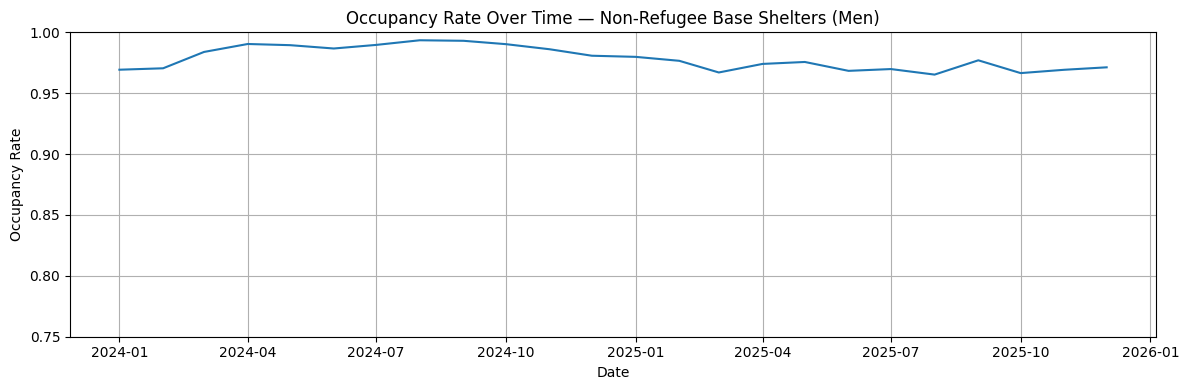

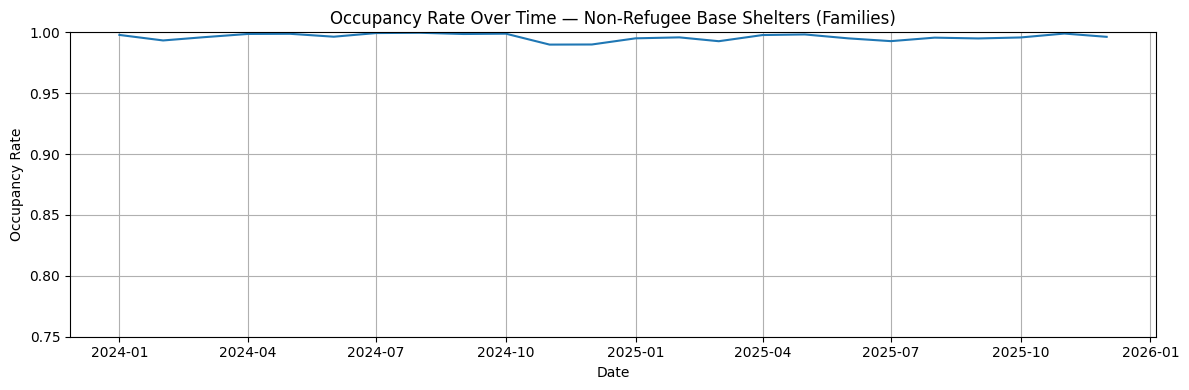

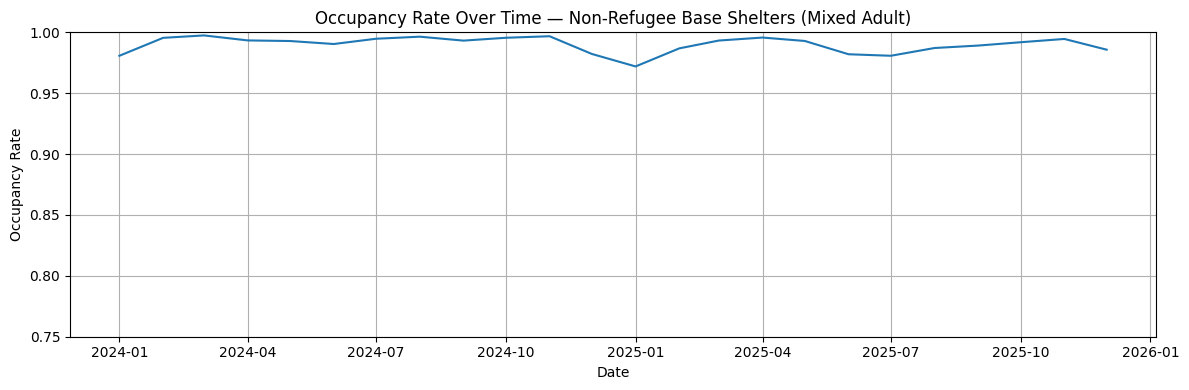

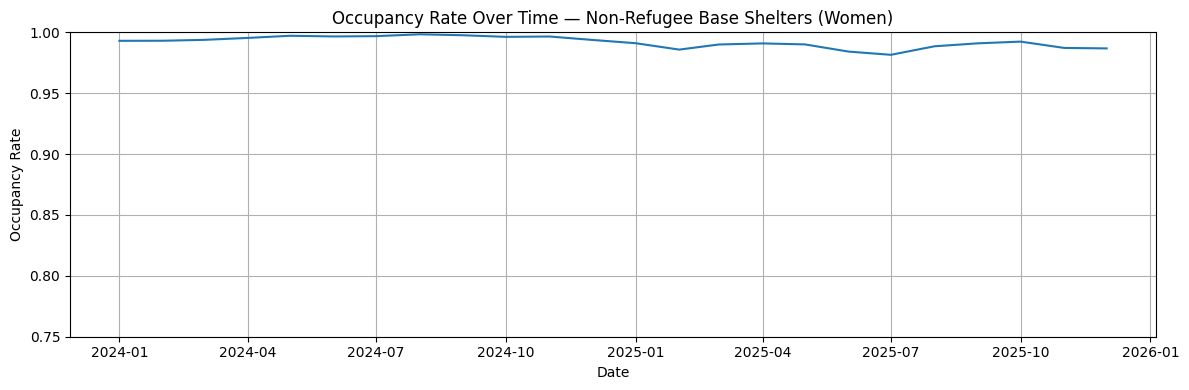

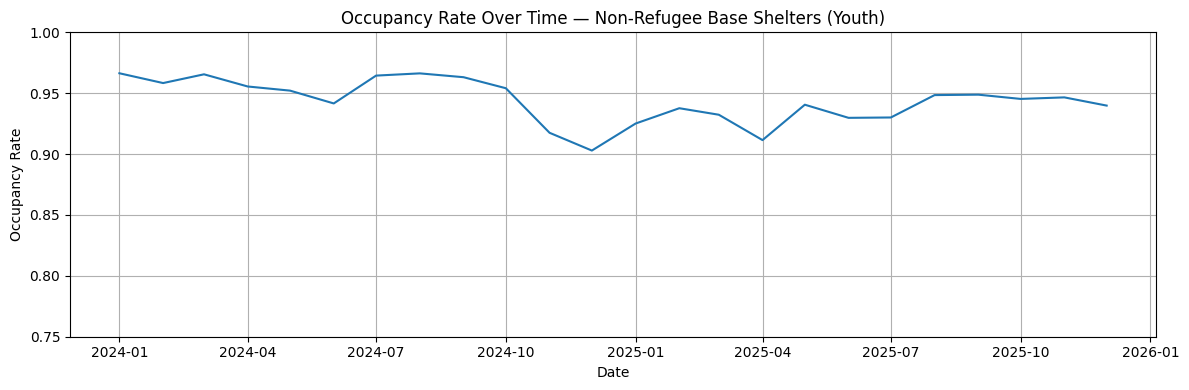

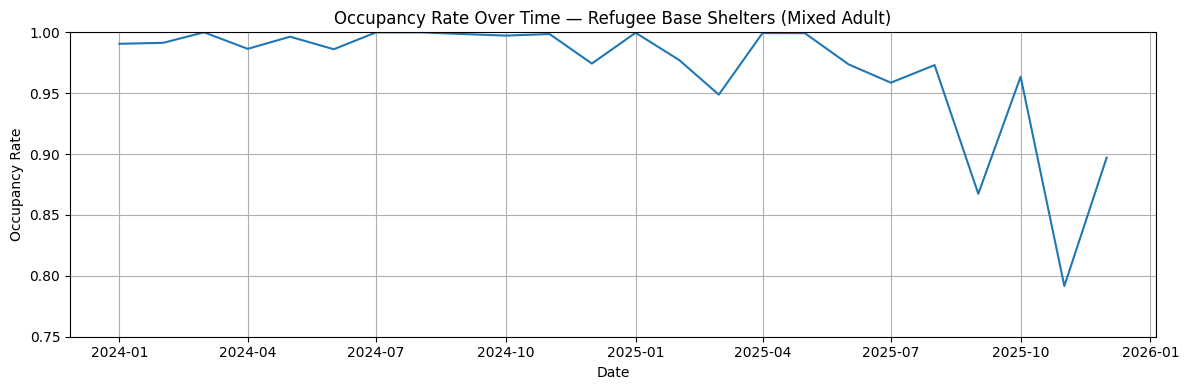

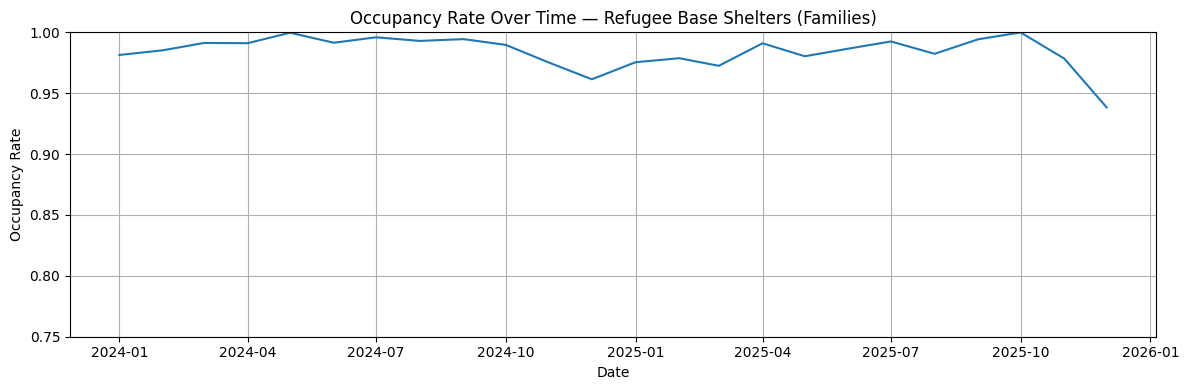

In [ ]:
import matplotlib.pyplot as plt

noref_sectors = homeless_df_base_noref['SECTOR'].unique()
ref_sectors = homeless_df_base_ref['SECTOR'].unique()

for sector in noref_sectors:
    name = sector.replace(' ', '_')
    df = globals()[f'homeless_df_base_noref_{name}']
    monthly = df.groupby(['OCCUPANCY_YEAR', 'OCCUPANCY_MONTH'])['OCCUPANCY_RATE'].mean().reset_index()
    monthly['date'] = pd.to_datetime(monthly[['OCCUPANCY_YEAR', 'OCCUPANCY_MONTH']].assign(day=1).rename(columns={'OCCUPANCY_YEAR': 'year', 'OCCUPANCY_MONTH': 'month'}))

    plt.figure(figsize=(12, 4))
    plt.plot(monthly['date'], monthly['OCCUPANCY_RATE'])
    plt.title(f'Occupancy Rate Over Time - Non-Refugee Base Shelters ({sector})')
    plt.xlabel('Date')
    plt.ylabel('Occupancy Rate')
    plt.ylim(0.75, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for sector in ref_sectors:
    name = sector.replace(' ', '_')
    df = globals()[f'homeless_df_base_ref_{name}']
    monthly = df.groupby(['OCCUPANCY_YEAR', 'OCCUPANCY_MONTH'])['OCCUPANCY_RATE'].mean().reset_index()
    monthly['date'] = pd.to_datetime(monthly[['OCCUPANCY_YEAR', 'OCCUPANCY_MONTH']].assign(day=1).rename(columns={'OCCUPANCY_YEAR': 'year', 'OCCUPANCY_MONTH': 'month'}))

    plt.figure(figsize=(12, 4))
    plt.plot(monthly['date'], monthly['OCCUPANCY_RATE'])
    plt.title(f'Occupancy Rate Over Time - Refugee Base Shelters ({sector})')
    plt.xlabel('Date')
    plt.ylabel('Occupancy Rate')
    plt.ylim(0.75, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# IGNORE CELLS BELOW